### Imports

In [25]:
import functools as ft
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.io as sio
import seaborn as sns
import yaml

from bagpy import bagreader

### Constants

In [26]:
# bag_dir = '../data/pb_rosbag/Linoleum/kwadrat/2023-01-16-17-42-29'
# bag_dir = '../data/pb_rosbag/Linoleum/kwadrat/Linoleum1'
bag_dir = '../data/pb_rosbag/Linoleum/osemka/Linoleum1'

### Load data from csv

In [27]:
bag_file_path = bag_dir + '.bag'
b = bagreader(bag_file_path)

[INFO]  Data folder ../data/pb_rosbag/Linoleum/osemka/Linoleum1 already exists. Not creating.


In [28]:
b.topic_table

,Topics,Types,Message Count,Frequency
0,/Servo_data,kin_odom_msg/Measurements,638,20.786726
1,/cmd_vel,geometry_msgs/Twist,1928,67.804265
2,/filter/quaternion,geometry_msgs/QuaternionStamped,3138,310.942546
3,/ground,std_msgs/String,2,0.597413
4,/imu/acceleration,geometry_msgs/Vector3Stamped,3138,316.169456
5,/imu/angular_velocity,geometry_msgs/Vector3Stamped,3138,305.997228
6,/imu/data,sensor_msgs/Imu,3138,307.951836
7,/imu/mag,geometry_msgs/Vector3Stamped,3134,313.827460
8,/imu/time_ref,sensor_msgs/TimeReference,3133,319.675622
9,/odom,nav_msgs/Odometry,1602,55.207824


In [29]:
topic_data = {file[:-4]: pd.read_csv(os.path.join(bag_dir, file)) for file in os.listdir(bag_dir)}

### Topics visualization

In [30]:
cmd_vel = topic_data['cmd_vel']
cmd_vel

,Time,linear.x,linear.y,linear.z,angular.x,angular.y,angular.z
0,1.673708e+09,0.00,0.0,0.0,0.0,0.0,0.000000
1,1.673708e+09,0.00,0.0,0.0,0.0,0.0,0.000000
2,1.673708e+09,0.09,0.0,0.0,0.0,0.0,0.578277
3,1.673708e+09,0.09,0.0,0.0,0.0,0.0,0.560940
4,1.673708e+09,0.09,0.0,0.0,0.0,0.0,0.545831
...,...,...,...,...,...,...,...
1923,1.673708e+09,0.09,0.0,0.0,0.0,0.0,-0.454547
1924,1.673708e+09,0.09,0.0,0.0,0.0,0.0,-0.464817
1925,1.673708e+09,0.09,0.0,0.0,0.0,0.0,-0.466900
1926,1.673708e+09,0.09,0.0,0.0,0.0,0.0,-0.456648


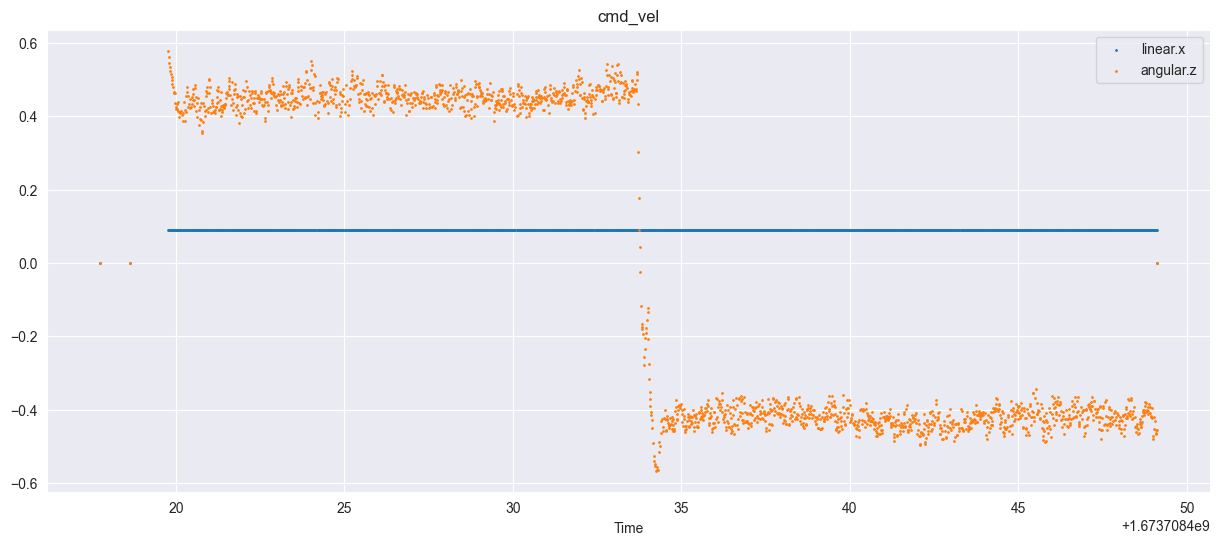

In [31]:
plt.rcParams['figure.figsize'] = [15, 6]
cols = ['linear.x', 'angular.z']
for col in cols:
    plt.scatter(x=cmd_vel['Time'], y=cmd_vel[col], s=1, label=col)
plt.title('cmd_vel')
plt.xlabel('Time')
plt.legend()
plt.show()

In [32]:
imu_acceleration = topic_data['imu-acceleration']
imu_acceleration

,Time,header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,vector.x,vector.y,vector.z
0,1.673708e+09,1348358,1673708416,984525903,imu_link,-0.054978,0.126792,9.999190
1,1.673708e+09,1348359,1673708416,984541143,imu_link,-0.046122,0.126029,10.042342
2,1.673708e+09,1348360,1673708416,984549243,imu_link,-0.042828,0.116442,10.023644
3,1.673708e+09,1348361,1673708416,984556993,imu_link,-0.050436,0.118466,10.039125
4,1.673708e+09,1348362,1673708416,984564768,imu_link,-0.037085,0.127892,9.993031
...,...,...,...,...,...,...,...,...
3133,1.673708e+09,1351491,1673708448,993434244,imu_link,-0.073884,0.232708,10.095622
3134,1.673708e+09,1351492,1673708448,993449639,imu_link,-0.076452,0.168073,10.083933
3135,1.673708e+09,1351493,1673708448,993457820,imu_link,-0.127939,0.165570,9.930819
3136,1.673708e+09,1351494,1673708448,993465769,imu_link,-0.133390,0.186067,9.949948


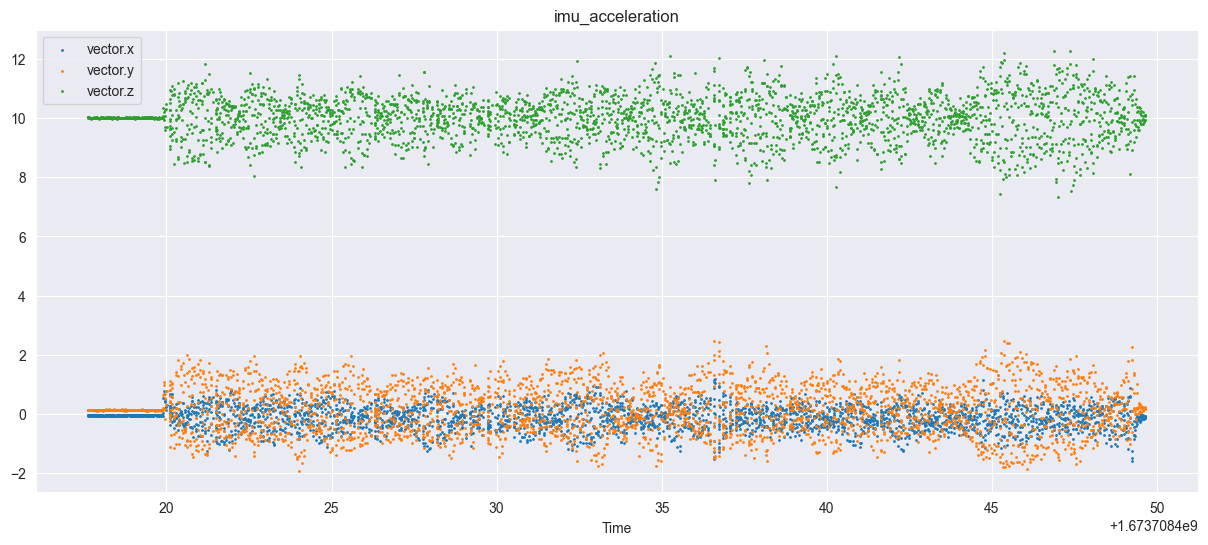

In [33]:
plt.rcParams['figure.figsize'] = [15, 6]
cols = ['vector.x', 'vector.y', 'vector.z']
for col in cols:
    plt.scatter(x=imu_acceleration['Time'], y=imu_acceleration[col], s=1, label=col)
plt.title('imu_acceleration')
plt.xlabel('Time')
plt.legend()
plt.show()

In [34]:
imu_angular_velocity = topic_data['imu-angular_velocity']
imu_angular_velocity

,Time,header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,vector.x,vector.y,vector.z
0,1.673708e+09,1348358,1673708416,984525903,imu_link,0.010628,0.000420,-0.012627
1,1.673708e+09,1348359,1673708416,984541143,imu_link,0.012417,0.000433,-0.013062
2,1.673708e+09,1348360,1673708416,984549243,imu_link,0.012639,-0.000769,-0.011730
3,1.673708e+09,1348361,1673708416,984556993,imu_link,0.011476,0.001029,-0.012453
4,1.673708e+09,1348362,1673708416,984564768,imu_link,0.012852,-0.000942,-0.012043
...,...,...,...,...,...,...,...,...
3133,1.673708e+09,1351491,1673708448,993434244,imu_link,0.011261,0.002421,-0.014373
3134,1.673708e+09,1351492,1673708448,993449639,imu_link,0.011436,-0.003070,-0.012208
3135,1.673708e+09,1351493,1673708448,993457820,imu_link,0.009562,-0.002772,-0.010341
3136,1.673708e+09,1351494,1673708448,993465769,imu_link,0.012166,-0.000352,-0.009613


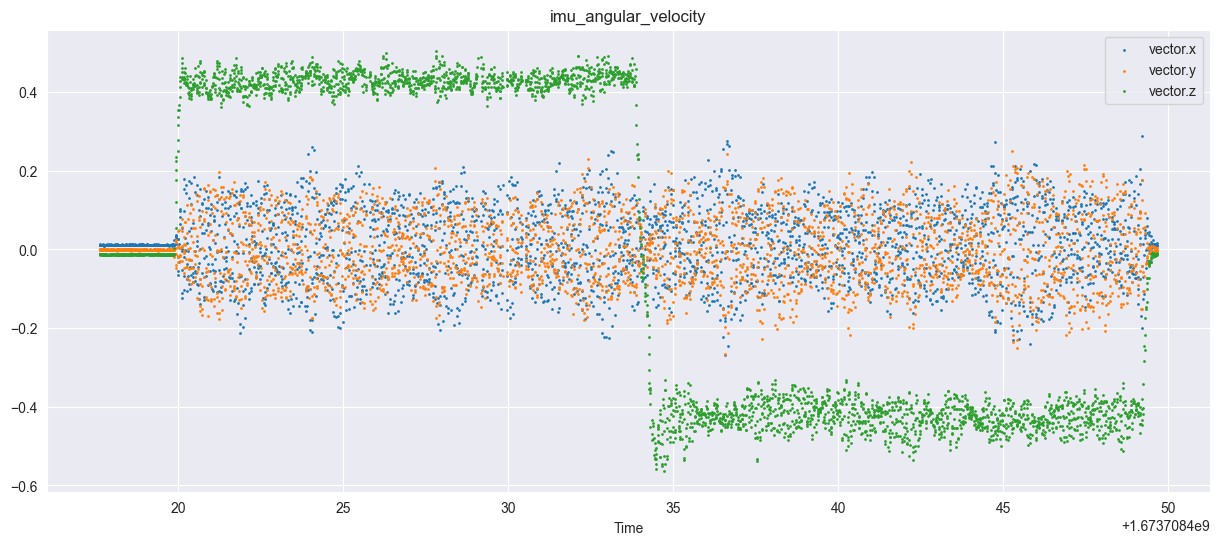

In [35]:
plt.rcParams['figure.figsize'] = [15, 6]
cols = ['vector.x', 'vector.y', 'vector.z']
for col in cols:
    plt.scatter(x=imu_angular_velocity['Time'], y=imu_angular_velocity[col], s=1, label=col)
plt.title('imu_angular_velocity')
plt.xlabel('Time')
plt.legend()
plt.show()

In [36]:
odom = topic_data['odom']
odom

,Time,header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,child_frame_id,pose.pose.position.x,pose.pose.position.y,pose.pose.position.z,pose.pose.orientation.x,...,pose.pose.orientation.z,pose.pose.orientation.w,pose.covariance,twist.twist.linear.x,twist.twist.linear.y,twist.twist.linear.z,twist.twist.angular.x,twist.twist.angular.y,twist.twist.angular.z,twist.covariance
0,1.673708e+09,687752,1673708416,995601485,odom,base_link,0.007129,0.001205,0.0,0.0,...,0.002395,0.999997,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.0,0.0,0.0,0.0,0.000000,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1.673708e+09,687753,1673708417,15607413,odom,base_link,0.007129,0.001205,0.0,0.0,...,0.002395,0.999997,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.0,0.0,0.0,0.0,0.000000,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1.673708e+09,687754,1673708417,35602432,odom,base_link,0.007129,0.001205,0.0,0.0,...,0.002395,0.999997,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.0,0.0,0.0,0.0,0.000000,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1.673708e+09,687755,1673708417,55649935,odom,base_link,0.007129,0.001205,0.0,0.0,...,0.002395,0.999997,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.0,0.0,0.0,0.0,0.000000,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1.673708e+09,687756,1673708417,75667823,odom,base_link,0.007129,0.001205,0.0,0.0,...,0.002395,0.999997,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.0,0.0,0.0,0.0,0.000000,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1597,1.673708e+09,689349,1673708448,935605171,odom,base_link,0.001328,-0.006609,0.0,0.0,...,-0.053984,0.998542,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000198,0.0,0.0,0.0,0.0,-0.001236,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1598,1.673708e+09,689350,1673708448,955669147,odom,base_link,0.001332,-0.006610,0.0,0.0,...,-0.053996,0.998541,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000198,0.0,0.0,0.0,0.0,-0.001236,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1599,1.673708e+09,689351,1673708448,975563879,odom,base_link,0.001332,-0.006610,0.0,0.0,...,-0.053996,0.998541,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.0,0.0,0.0,0.0,0.000000,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1600,1.673708e+09,689352,1673708448,995565013,odom,base_link,0.001332,-0.006610,0.0,0.0,...,-0.053996,0.998541,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.0,0.0,0.0,0.0,0.000000,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


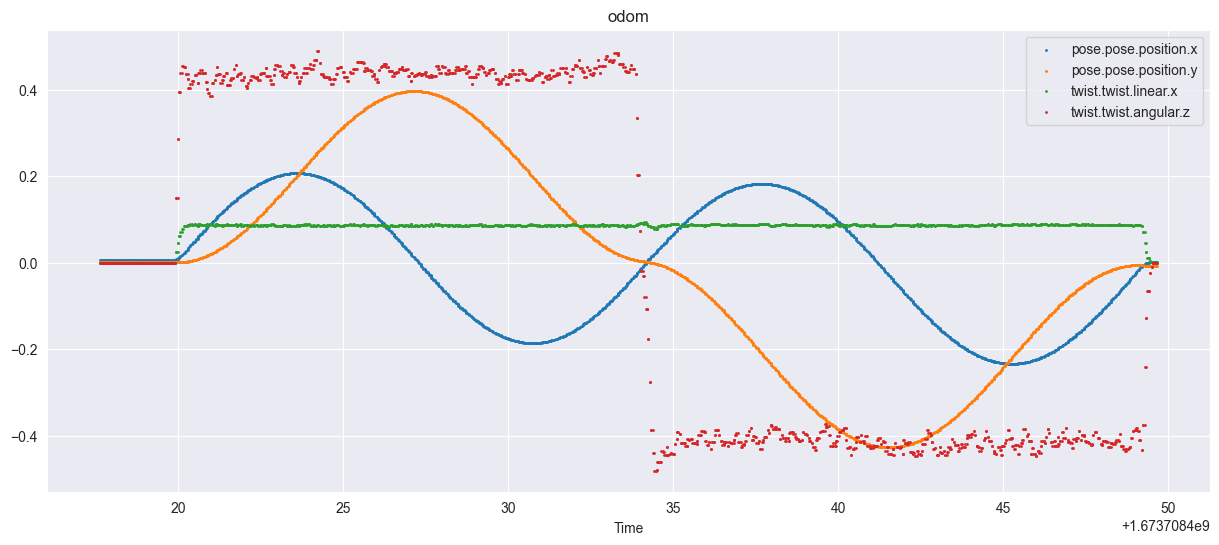

In [37]:
plt.rcParams['figure.figsize'] = [15, 6]
cols = ['pose.pose.position.x', 'pose.pose.position.y', 'twist.twist.linear.x', 'twist.twist.angular.z']
for col in cols:
    plt.scatter(x=odom['Time'], y=odom[col], s=1, label=col)
plt.title('odom')
plt.xlabel('Time')
plt.legend()
plt.show()

In [38]:
servo_data = topic_data['Servo_data']
servo_data

,Time,values
0,1.673708e+09,[ID: 1\nVoltage: 10.399999618530273\nAmper: -1...
1,1.673708e+09,[ID: 1\nVoltage: 10.399999618530273\nAmper: -1...
2,1.673708e+09,"[ID: 1\nVoltage: 10.5\nAmper: -14.0, ID: 2\nVo..."
3,1.673708e+09,"[ID: 1\nVoltage: 10.5\nAmper: -14.0, ID: 2\nVo..."
4,1.673708e+09,[ID: 1\nVoltage: 10.5\nAmper: -13.899999618530...
...,...,...
633,1.673708e+09,[ID: 1\nVoltage: 10.399999618530273\nAmper: 4....
634,1.673708e+09,[ID: 1\nVoltage: 10.399999618530273\nAmper: 6....
635,1.673708e+09,[ID: 1\nVoltage: 10.399999618530273\nAmper: 7....
636,1.673708e+09,[ID: 1\nVoltage: 10.399999618530273\nAmper: 8....


In [39]:
data = servo_data['values'].tolist()
data = [line.replace(', ', '];[') for line in data]
data = [line.replace('[', '') for line in data]
data = [line.replace(']', '') for line in data]
data = [line.split(sep=';') for line in data]
data = [[yaml.safe_load(line) for line in separate_lines] for separate_lines in data]
time = servo_data['Time']
columns = ['Power_' + str(idx + 1) for idx in range(len(data[0]))]
columns_left = ['Power_' + str(idx + 1) for idx in range(len(data[0])) if idx % 2 == 0]
columns_right = ['Power_' + str(idx + 1) for idx in range(len(data[0])) if idx % 2 != 0]
power = pd.DataFrame([[abs(tuple(dictionary.values())[1] * tuple(dictionary.values())[2]) / 1e3 for dictionary in line] for line in data], columns=columns)
power_left = pd.DataFrame([[abs(tuple(dictionary.values())[1] * tuple(dictionary.values())[2]) / 1e3 for idx, dictionary in enumerate(line) if idx % 2 == 0] for line in data], columns=columns_left)
power_right = pd.DataFrame([[abs(tuple(dictionary.values())[1] * tuple(dictionary.values())[2]) / 1e3 for idx, dictionary in enumerate(line) if idx % 2 != 0] for line in data], columns=columns_right)
mean_power = pd.concat([time, power.mean(axis=1)], axis=1)
mean_power.columns = ['Time', 'mean_power']
mean_power_left = pd.concat([time, power_left.mean(axis=1)], axis=1)
mean_power_left.columns = ['Time', 'mean_power_left']
mean_power_right = pd.concat([time, power_right.mean(axis=1)], axis=1)
mean_power_right.columns = ['Time', 'mean_power_right']
power = pd.concat([time, power], axis=1)

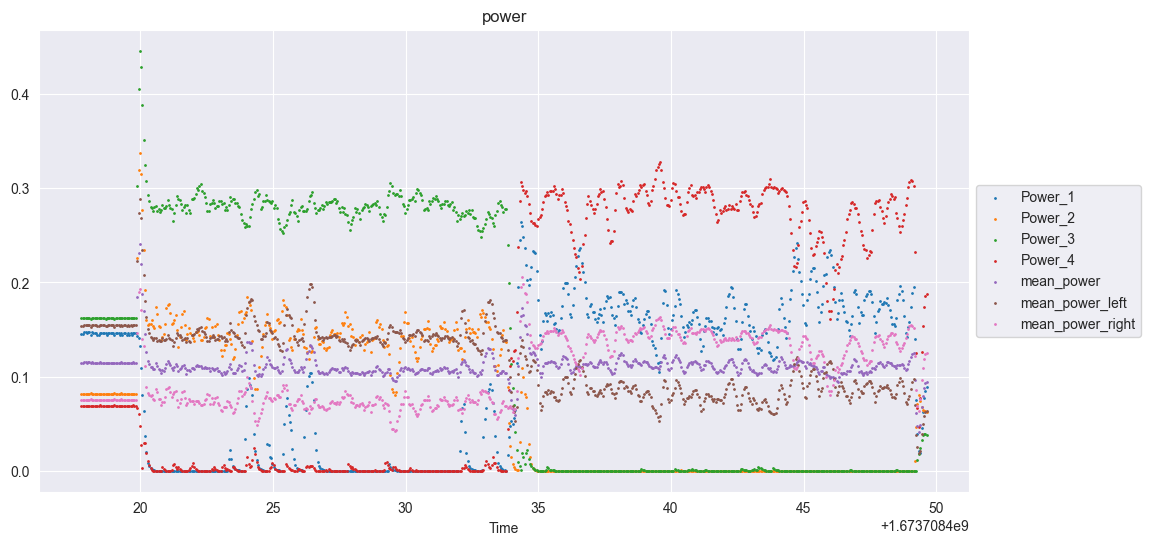

In [40]:
_, ax = plt.subplots(figsize=(15, 6))
for column in power.columns[1:]:
    ax.scatter(x=power['Time'], y=power[column], s=1, label=column)
ax.scatter(x=mean_power['Time'], y=mean_power['mean_power'], s=1, label='mean_power')
ax.scatter(x=mean_power_left['Time'], y=mean_power_left['mean_power_left'], s=1, label='mean_power_left')
ax.scatter(x=mean_power_right['Time'], y=mean_power_right['mean_power_right'], s=1, label='mean_power_right')
ax.set_title('power')
ax.set_xlabel('Time')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### Refine data

In [41]:
imu_data = topic_data['imu-data']

In [42]:
cmd_vel_refined = cmd_vel.drop(columns=['linear.y', 'linear.z', 'angular.x', 'angular.y'])
imu_acceleration_refined = imu_data[['Time', 'linear_acceleration.x', 'linear_acceleration.y', 'linear_acceleration.z']]
imu_angular_velocity_refined = imu_data[['Time', 'angular_velocity.x', 'angular_velocity.y', 'angular_velocity.z']]
odom_refined = odom.drop(columns=['header.seq', 'header.stamp.secs', 'header.stamp.nsecs', 'header.frame_id', 'child_frame_id',
                                  'pose.covariance', 'twist.covariance',
                                  'pose.pose.position.z',
                                  'pose.pose.orientation.x', 'pose.pose.orientation.y', 'pose.pose.orientation.z', 'pose.pose.orientation.w',
                                  'twist.twist.linear.y', 'twist.twist.linear.z', 'twist.twist.angular.x', 'twist.twist.angular.y'])

In [43]:
dataframes = [cmd_vel_refined, imu_acceleration_refined, imu_angular_velocity_refined, odom_refined, mean_power, mean_power_left, mean_power_right]
dataframe = ft.reduce(lambda left, right: pd.merge(left, right, how='outer', on='Time'), dataframes)
dataframe.ffill(inplace=True)
dataframe.bfill(inplace=True)
dataframe['Time'] -= dataframe['Time'].min()
dataframe.set_index('Time', inplace=True)
dataframe

,linear.x,angular.z,linear_acceleration.x,linear_acceleration.y,linear_acceleration.z,angular_velocity.x,angular_velocity.y,angular_velocity.z,pose.pose.position.x,pose.pose.position.y,twist.twist.linear.x,twist.twist.angular.z,mean_power,mean_power_left,mean_power_right
Time,,,,,,,,,,,,,,,
0.000000,0.0,0.0,-0.054978,0.126792,9.999190,0.010628,0.000420,-0.012627,0.007129,0.001205,0.0,0.0,0.114527,0.154175,0.074880
0.000006,0.0,0.0,-0.054978,0.126792,9.999190,0.010628,0.000420,-0.012627,0.007129,0.001205,0.0,0.0,0.114527,0.154175,0.074880
0.000691,0.0,0.0,-0.046122,0.126029,10.042342,0.012417,0.000433,-0.013062,0.007129,0.001205,0.0,0.0,0.114527,0.154175,0.074880
0.000719,0.0,0.0,-0.042828,0.116442,10.023644,0.012639,-0.000769,-0.011730,0.007129,0.001205,0.0,0.0,0.114527,0.154175,0.074880
0.000741,0.0,0.0,-0.050436,0.118466,10.039125,0.011476,0.001029,-0.012453,0.007129,0.001205,0.0,0.0,0.114527,0.154175,0.074880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32.001467,0.0,0.0,-0.076452,0.168073,10.083933,0.011436,-0.003070,-0.012208,0.001332,-0.006610,0.0,0.0,0.093958,0.063010,0.124905
32.004250,0.0,0.0,-0.127939,0.165570,9.930819,0.009562,-0.002772,-0.010341,0.001332,-0.006610,0.0,0.0,0.093958,0.063010,0.124905
32.009659,0.0,0.0,-0.133390,0.186067,9.949948,0.012166,-0.000352,-0.009613,0.001332,-0.006610,0.0,0.0,0.093958,0.063010,0.124905


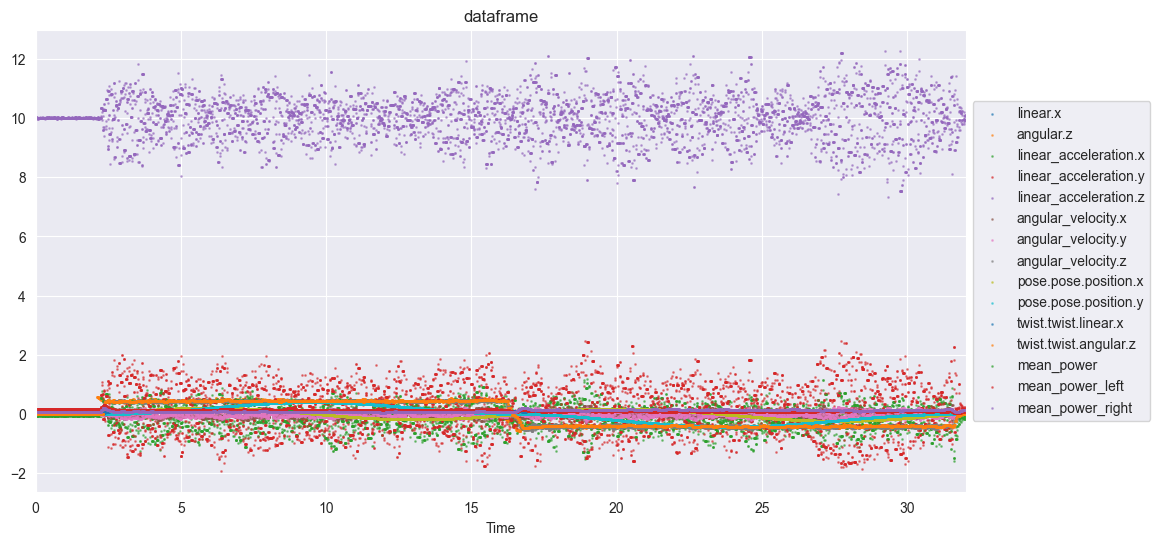

In [44]:
fig, ax = plt.subplots(figsize=(15, 6))

for column in dataframe.columns:
    ax.scatter(x=dataframe.index, y=dataframe[column], s=1, alpha=0.5, label=column)
ax.set_title('dataframe')
ax.set_xlabel('Time')
ax.set_xlim(dataframe.index[0], dataframe.index[-1])

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### Correlation matrix

(15.5, -0.5)

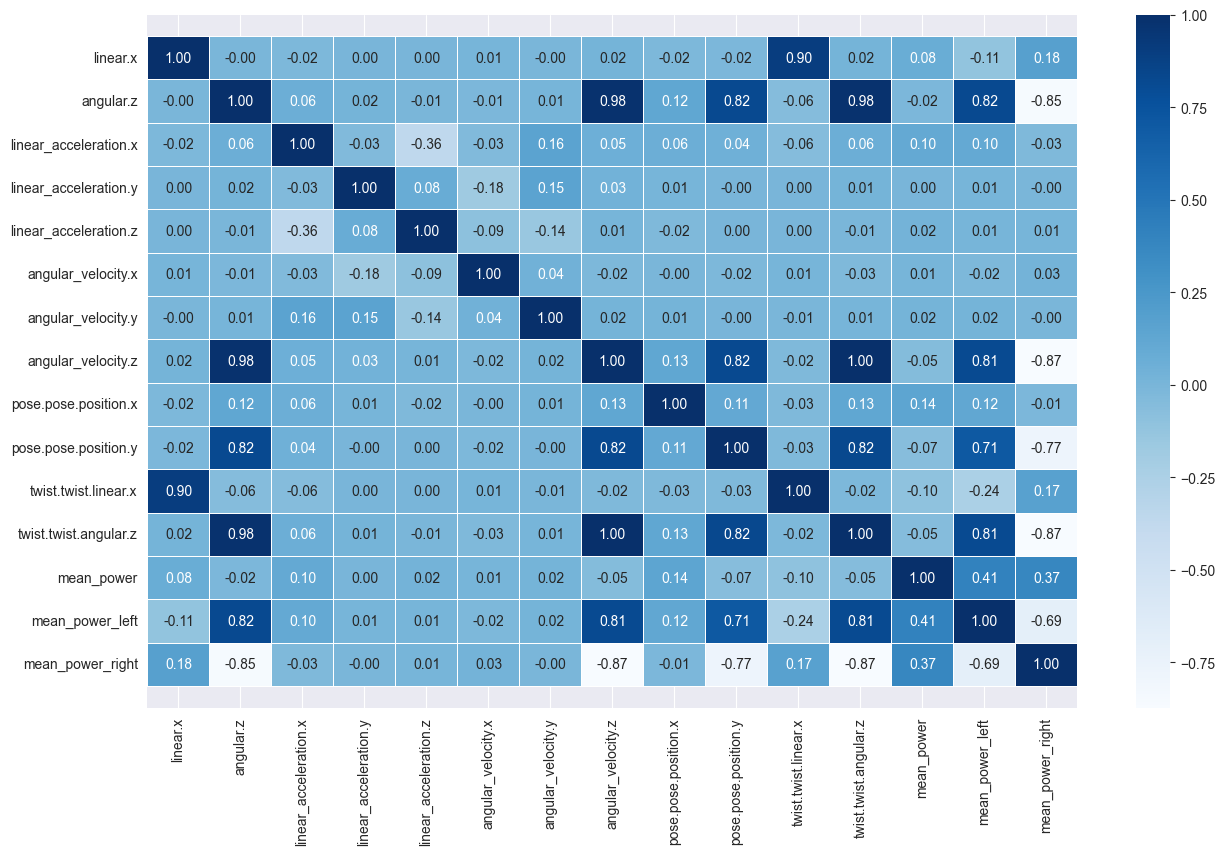

In [45]:
corr_matrix = dataframe.corr()
fig, ax = plt.subplots(figsize=(15, 9))
sns.heatmap(corr_matrix, annot=True, linewidths=0.5, fmt=".2f", cmap="Blues")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

### Correlation visualizations

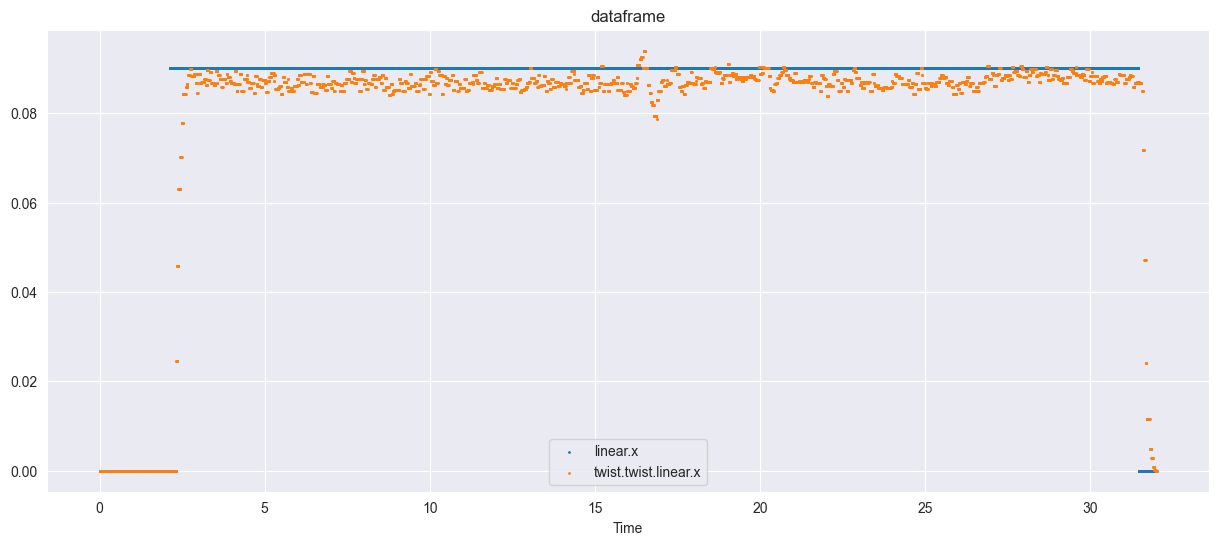

In [46]:
# cmd_vel / odom
plt.rcParams['figure.figsize'] = [15, 6]
cols = ['linear.x', 'twist.twist.linear.x']
for col in cols:
    plt.scatter(x=dataframe.index, y=dataframe[col], s=1, label=col)
plt.title('dataframe')
plt.xlabel('Time')
plt.legend()
plt.show()

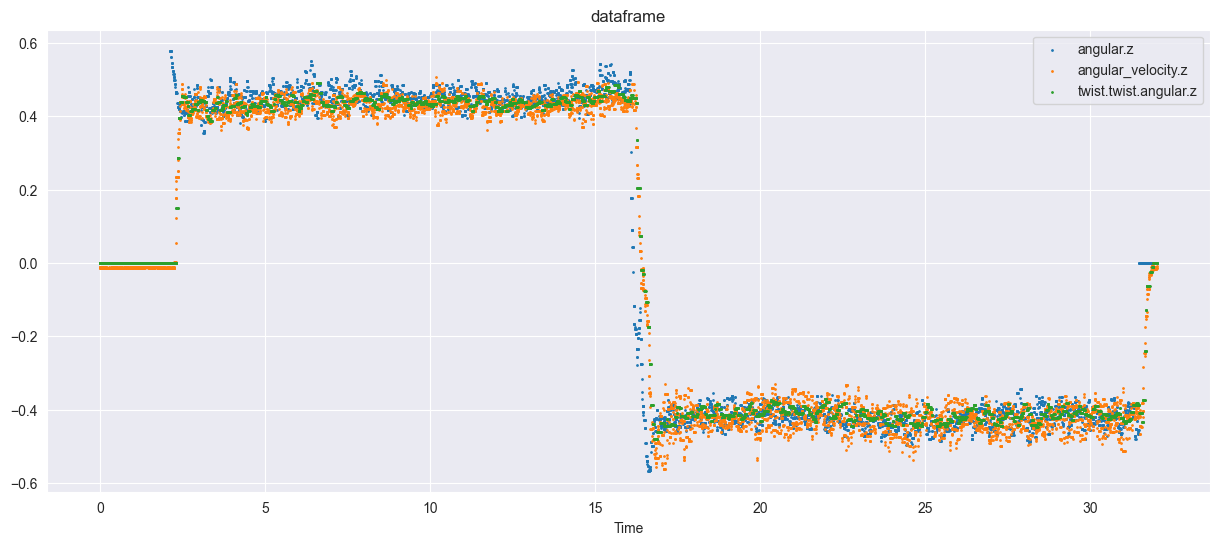

In [47]:
# cmd_vel / imu_angular_velocity / odom
plt.rcParams['figure.figsize'] = [15, 6]
cols = ['angular.z', 'angular_velocity.z', 'twist.twist.angular.z']
for col in cols:
    plt.scatter(x=dataframe.index, y=dataframe[col], s=1, label=col)
plt.title('dataframe')
plt.xlabel('Time')
plt.legend()
plt.show()

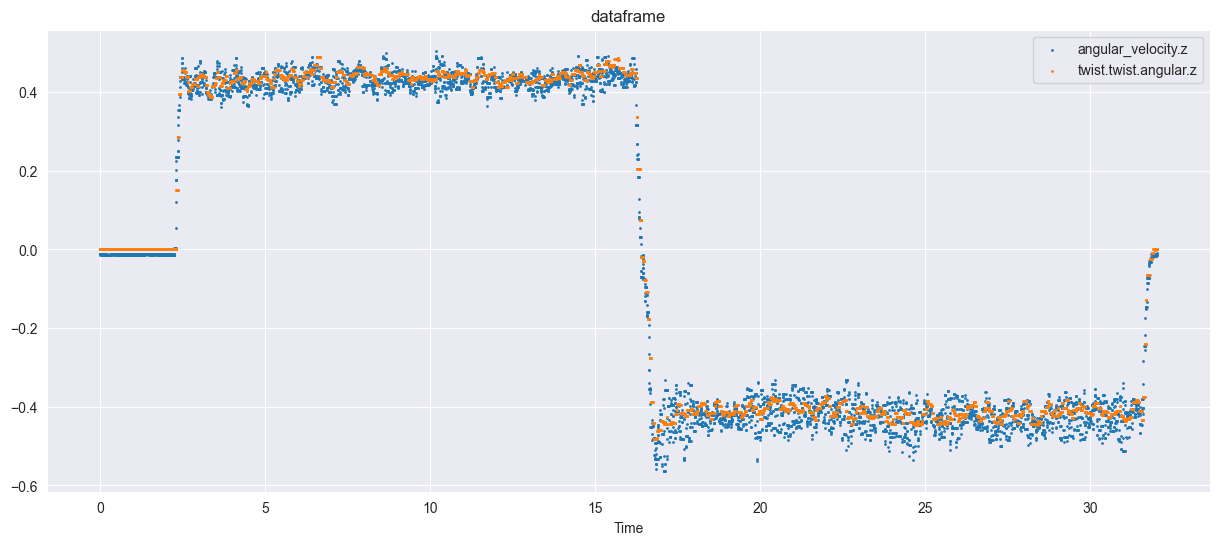

In [48]:
# imu_angular_velocity / odom
plt.rcParams['figure.figsize'] = [15, 6]
cols = ['angular_velocity.z', 'twist.twist.angular.z']
for col in cols:
    plt.scatter(x=dataframe.index, y=dataframe[col], s=1, label=col)
plt.title('dataframe')
plt.xlabel('Time')
plt.legend()
plt.show()